In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load in the dataset
df = pd.read_csv("ecommerce_churn_data.csv")

# Drop CustomerID (unique Identifier)
df = df.drop(columns=["CustomerID"])

# Drop row row with missing value
df = df.dropna()

# Remove Leakage columns
leak_cols = ["Complain", "SatisfactionScore", "CashbackAmount", "OrderCount", "DaySinceLastOrder"]
df = df.drop(columns=leak_cols)

# Split features and target
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = ["PreferredLoginDevice", "Gender"]

# Perform one hot encoding on categorical columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
if cat_cols:
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_test_cat  = encoder.transform(X_test[cat_cols])
    cat_feature_names = encoder.get_feature_names_out(cat_cols)
    X_train_cat = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
    X_test_cat  = pd.DataFrame(X_test_cat,  columns=cat_feature_names, index=X_test.index)
else:
    # no categorical columns
    X_train_cat = pd.DataFrame(index=X_train.index)
    X_test_cat  = pd.DataFrame(index=X_test.index)

# Fit scaler on numeric columns using X_train only, transform both
scaler = StandardScaler()
if len(num_cols) > 0:
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_test_num  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_test_num  = pd.DataFrame(index=X_test.index)

# Combine processed numeric + categorical parts
X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_proc  = pd.concat([X_test_num,  X_test_cat],  axis=1)



In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Create and train model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_proc, y_train)

# Predict & evaluate
y_pred_rf = rf_model.predict(X_test_proc)
y_proba_rf = rf_model.predict_proba(X_test_proc)[:, 1]

print("\nRandom Forest Results")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1554
           1       0.96      0.90      0.93       487

    accuracy                           0.97      2041
   macro avg       0.96      0.94      0.95      2041
weighted avg       0.97      0.97      0.97      2041

Confusion Matrix:
 [[1534   20]
 [  50  437]]
ROC AUC Score: 0.9904617876897137
Random Forest Accuracy: 0.965703086722195


In [83]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Train MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_proc, y_train)

# Predict
y_pred = mlp.predict(X_test_proc)
y_proba = mlp.predict_proba(X_test_proc)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1554
           1       0.87      0.73      0.79       487

    accuracy                           0.91      2041
   macro avg       0.89      0.85      0.87      2041
weighted avg       0.91      0.91      0.91      2041

Confusion Matrix:
 [[1500   54]
 [ 131  356]]
Accuracy: 0.9093581577658011
ROC AUC: 0.9508521428439294


In [85]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

X_train_np = X_train_proc.values
X_test_np  = X_test_proc.values
y_train_np = y_train.values
y_test_np  = y_test.values

tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=4,
    gamma=1.3, lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax"
)

tabnet.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0
)

preds = tabnet.predict(X_test_np)
probs = tabnet.predict_proba(X_test_np)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test_np, preds))
print("ROC AUC:", roc_auc_score(y_test_np, probs))


D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.48132 |  0:00:02s
epoch 1  | loss: 0.39493 |  0:00:05s
epoch 2  | loss: 0.36823 |  0:00:07s
epoch 3  | loss: 0.35252 |  0:00:10s
epoch 4  | loss: 0.34524 |  0:00:13s
epoch 5  | loss: 0.33117 |  0:00:15s
epoch 6  | loss: 0.33637 |  0:00:17s
epoch 7  | loss: 0.32519 |  0:00:20s
epoch 8  | loss: 0.31527 |  0:00:22s
epoch 9  | loss: 0.31161 |  0:00:24s
epoch 10 | loss: 0.30713 |  0:00:27s
epoch 11 | loss: 0.29324 |  0:00:29s
epoch 12 | loss: 0.28964 |  0:00:32s
epoch 13 | loss: 0.27837 |  0:00:35s
epoch 14 | loss: 0.27954 |  0:00:38s
epoch 15 | loss: 0.27276 |  0:00:41s
epoch 16 | loss: 0.27698 |  0:00:43s
epoch 17 | loss: 0.26517 |  0:00:46s
epoch 18 | loss: 0.26353 |  0:00:49s
epoch 19 | loss: 0.26614 |  0:00:51s
epoch 20 | loss: 0.2638  |  0:00:54s
epoch 21 | loss: 0.26442 |  0:00:56s
epoch 22 | loss: 0.25193 |  0:00:59s
epoch 23 | loss: 0.24123 |  0:01:01s
epoch 24 | loss: 0.25407 |  0:01:03s
epoch 25 | loss: 0.27441 |  0:01:06s
epoch 26 | loss: 0.25004 |  0:01:08s
e

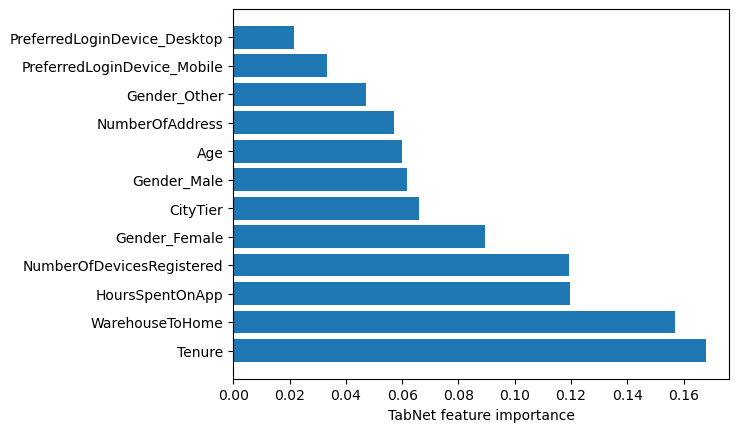

In [90]:
import matplotlib.pyplot as plt
feat_names = X_train_proc.columns.tolist()
plt.barh([feat_names[i] for i in idx[:30]], fi[idx[:30]])
plt.xlabel("TabNet feature importance")
plt.show()


In [92]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

X_train_np = X_train_proc.values
X_test_np  = X_test_proc.values
y_train_np = y_train.values
y_test_np  = y_test.values

tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=4,
    gamma=1.3, lambda_sparse=1e-2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax"
)

tabnet.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0
)

preds = tabnet.predict(X_test_np)
probs = tabnet.predict_proba(X_test_np)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test_np, preds))
print("ROC AUC:", roc_auc_score(y_test_np, probs))


D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.48484 |  0:00:05s
epoch 1  | loss: 0.39812 |  0:00:12s
epoch 2  | loss: 0.36912 |  0:00:17s
epoch 3  | loss: 0.34841 |  0:00:23s
epoch 4  | loss: 0.34613 |  0:00:28s
epoch 5  | loss: 0.34948 |  0:00:33s
epoch 6  | loss: 0.3334  |  0:00:39s
epoch 7  | loss: 0.32022 |  0:00:45s
epoch 8  | loss: 0.31185 |  0:00:51s
epoch 9  | loss: 0.29943 |  0:00:56s
epoch 10 | loss: 0.30098 |  0:01:01s
epoch 11 | loss: 0.30249 |  0:01:07s
epoch 12 | loss: 0.3057  |  0:01:12s
epoch 13 | loss: 0.29404 |  0:01:17s
epoch 14 | loss: 0.30034 |  0:01:23s
epoch 15 | loss: 0.28277 |  0:01:29s
epoch 16 | loss: 0.26941 |  0:01:34s
epoch 17 | loss: 0.27789 |  0:01:40s
epoch 18 | loss: 0.2679  |  0:01:45s
epoch 19 | loss: 0.26901 |  0:01:50s
epoch 20 | loss: 0.26335 |  0:01:55s
epoch 21 | loss: 0.26488 |  0:02:01s
epoch 22 | loss: 0.27558 |  0:02:07s
epoch 23 | loss: 0.2687  |  0:02:13s
epoch 24 | loss: 0.2743  |  0:02:18s
epoch 25 | loss: 0.27014 |  0:02:24s
epoch 26 | loss: 0.26507 |  0:02:29s
e

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Create and train model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_proc, y_train)

# Predict & evaluate
y_pred_rf = rf_model.predict(X_test_proc)
y_proba_rf = rf_model.predict_proba(X_test_proc)[:, 1]

print("\nRandom Forest Results")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Save Random Forest predictions for ensemble
rf_results = pd.DataFrame({
    "CustomerID": X_test.index,
    "actual": y_test.values,
    "pred_rf": y_pred_rf,
    "prob_rf": y_proba_rf
})

rf_results.to_csv("rf_predictions.csv", index=False)
print("Saved rf_predictions.csv")



Random Forest Results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1554
           1       0.96      0.90      0.93       487

    accuracy                           0.97      2041
   macro avg       0.96      0.94      0.95      2041
weighted avg       0.97      0.97      0.97      2041

Confusion Matrix:
 [[1534   20]
 [  50  437]]
ROC AUC Score: 0.9904617876897137
Random Forest Accuracy: 0.965703086722195
Saved rf_predictions.csv


In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

X_train_np = X_train_proc.values
X_test_np  = X_test_proc.values
y_train_np = y_train.values
y_test_np  = y_test.values

tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=4,
    gamma=1.3, lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax"
)

tabnet.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0
)

preds = tabnet.predict(X_test_np)
probs = tabnet.predict_proba(X_test_np)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test_np, preds))
print("ROC AUC:", roc_auc_score(y_test_np, probs))

# Save TabNet predictions for ensemble
tabnet_results = pd.DataFrame({
    "CustomerID": X_test.index,      
    "actual": y_test_np,
    "pred_tabnet": preds,
    "prob_tabnet": probs
})

tabnet_results.to_csv("tabnet_predictions.csv", index=False)
print("Saved tabnet_predictions.csv")

D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
D:\Anaconda\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.48132 |  0:00:02s
epoch 1  | loss: 0.39493 |  0:00:05s
epoch 2  | loss: 0.36823 |  0:00:08s
epoch 3  | loss: 0.35252 |  0:00:10s
epoch 4  | loss: 0.34524 |  0:00:13s
epoch 5  | loss: 0.33117 |  0:00:15s
epoch 6  | loss: 0.33637 |  0:00:18s
epoch 7  | loss: 0.32519 |  0:00:21s
epoch 8  | loss: 0.31527 |  0:00:23s
epoch 9  | loss: 0.31161 |  0:00:25s
epoch 10 | loss: 0.30713 |  0:00:28s
epoch 11 | loss: 0.29324 |  0:00:30s
epoch 12 | loss: 0.28964 |  0:00:33s
epoch 13 | loss: 0.27837 |  0:00:35s
epoch 14 | loss: 0.27954 |  0:00:38s
epoch 15 | loss: 0.27276 |  0:00:40s
epoch 16 | loss: 0.27698 |  0:00:43s
epoch 17 | loss: 0.26517 |  0:00:45s
epoch 18 | loss: 0.26353 |  0:00:48s
epoch 19 | loss: 0.26614 |  0:00:50s
epoch 20 | loss: 0.2638  |  0:00:53s
epoch 21 | loss: 0.26442 |  0:00:55s
epoch 22 | loss: 0.25193 |  0:00:57s
epoch 23 | loss: 0.24123 |  0:01:00s
epoch 24 | loss: 0.25407 |  0:01:02s
epoch 25 | loss: 0.27441 |  0:01:05s
epoch 26 | loss: 0.25004 |  0:01:07s
e

In [11]:
# Merge prediction files
combined = rf.merge(tabnet, on="CustomerID", suffixes=("_rf", "_tabnet"))

# Create a unified actual column (handles actual_rf, actual_tabnet, etc.)
if "actual" in combined.columns:
    pass
elif "actual_rf" in combined.columns:
    combined["actual"] = combined["actual_rf"]
elif "actual_x" in combined.columns:
    combined["actual"] = combined["actual_x"]

# Average probabilities
combined["prob_avg"] = (combined["prob_rf"] + combined["prob_tabnet"]) / 2

# Convert to class prediction
combined["pred_avg"] = (combined["prob_avg"] >= 0.5).astype(int)

# Evaluate ensemble
print("Ensemble Classification Report:\n")
print(classification_report(combined["actual"], combined["pred_avg"]))

auc = roc_auc_score(combined["actual"], combined["prob_avg"])
acc = accuracy_score(combined["actual"], combined["pred_avg"])

print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")


Ensemble Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1554
           1       0.94      0.90      0.92       487

    accuracy                           0.96      2041
   macro avg       0.96      0.94      0.95      2041
weighted avg       0.96      0.96      0.96      2041

ROC AUC: 0.9877
Accuracy: 0.9628
